# Results

| **avg accuracy**    | logistic | xgboost |
|---------------------|----------|---------|
| per file            | 0.66     | 0.57    |
| train all, test one | 0.58     | 0.54    |
| train one, test all | 0.53     | 0.58    |

In [1]:
#
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_squared_error
from sklearn.metrics import average_precision_score
from sklearn.metrics import PrecisionRecallDisplay, precision_recall_curve
from util.rank_metrics import mean_average_precision
from sklearn.model_selection import LeaveOneOut

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

import xgboost as xgb
xgb.set_config(verbosity=1)

#
from util.Util import plot_accuracies, read_csv
from df_features import DataFrameFeatures
from df_classifier import DataFrameClassifier

file_names = ['Computer vision','Consulting','Fintech','Fish processing equipment','Healthcare','House builders','Industrial vertical investor','Innovative','IoT','IT freelance','M&A advisors','Manufacturers','Online games','Payments tech','PE fund','Procurement software','Resource-efficiency','SaaS','Sustainability','Wind turbine tech']

In [2]:
# Read GLOVE embeddings from file
glove_df = read_csv('util/glove/glove.42B.300d.txt', sep=" ", index_col=0, quoting=3, header=None)
glove_embeddings = {key: val.values for key, val in tqdm(glove_df.T.items())}
del glove_df # Delete glove_df to free up memory

* Reading CSV from path: util/glove/glove.42B.300d.txt. Size: (1917494, 300)


1917494it [00:23, 81279.83it/s]


In [3]:
np.random.seed(0)

# Read the cleaned dataframe
full_df = read_csv('data/processed_data/cleaned_v1.csv')

# Create tf-idf vectorizer using the main col and a max of 250 features
main_col = 'description_no_stopwords'
vectorizer = TfidfVectorizer(max_features=50, analyzer='char')
vectorizer.fit_transform(full_df[main_col])

full_dff = DataFrameFeatures(df=full_df, vectorizer=vectorizer, main_col=main_col, verbose=False)

* Reading CSV from path: data/processed_data/cleaned_v1.csv. Size: (60122, 7)


# Classification

## Leave one out

### Logistic | Leave one out per file

In [41]:
mcnemar = {}
names = {}

# Calculate the accuracies
for i, file_name in tqdm(enumerate(file_names)):

    dfc = DataFrameClassifier(dff=full_dff, glove_embeddings=glove_embeddings, file_name=file_name, verbose=False)
    
    # X, y = dfc.get_tfidf_vectors()
    X, y = dfc.get_feature_vectors()
    
    loo = LeaveOneOut()

    mcnemar[file_name] = []

    clf = LogisticRegression(random_state=0, class_weight='balanced')

    for train_index, test_index in loo.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        clf.fit(X_train, y_train)
        correct_classification = (y_test == clf.predict(X_test)).astype(int).astype(str)
        mcnemar[file_name].extend(correct_classification)

# Accuracy
flat = [int(x) for x in list(mcnemar.values()) for x in x]
sum(flat) / len(flat)

20it [00:29,  1.46s/it]


0.5809294871794872

In [24]:
import json
with open('data/mcnemar/mcnemar_custom_names.json', 'w') as fp:
    json.dump(names, fp)

### XGBoost | Leave one out per file

In [111]:
mcnemar = {}

# Calculate the accuracies
for i, file_name in tqdm(enumerate(file_names)):

    dfc = DataFrameClassifier(dff=full_dff, glove_embeddings=glove_embeddings, file_name=file_name, verbose=False)
    
    X, y = dfc.get_tfidf_vectors()
    # X, y = dfc.get_feature_vectors()

    loo = LeaveOneOut()

    mcnemar[file_name] = []

    xg = xgb.XGBClassifier(use_label_encoder=False, eval_metric='map')

    for train_index, test_index in loo.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        xg.fit(X_train, y_train)
        correct_classification = (y_test == xg.predict(X_test)[0]).astype(int).astype(str)
        mcnemar[file_name].extend(correct_classification)

# Accuracy
flat = [int(x) for x in list(mcnemar.values()) for x in x]
sum(flat) / len(flat)

20it [00:43,  2.19s/it]


0.6666666666666666

In [95]:
import json
with open('data/mcnemar/xgboost_mcnemar_custom.json', 'w') as fp:
    json.dump(mcnemar, fp)

## Per file: Train on labelled, test on initials 

#### Logistic regression

In [4]:
accuracies = {}

for file_name in tqdm(file_names):
    dfc = DataFrameClassifier(dff=full_dff, glove_embeddings=glove_embeddings, file_name=file_name, verbose=False)
    
    X_train, y_train, X_test, y_test = dfc.get_feature_vectors(split=True)

    clf = LogisticRegression(random_state=0, class_weight='balanced', fit_intercept=False).fit(X_train, y_train)
    accuracies[file_name] = clf.score(X_test,y_test)
    

100%|██████████| 20/20 [00:27<00:00,  1.39s/it]


In [5]:
print(f"Average accuracy: {np.mean(list(accuracies.values()))}")
print("---")
print(accuracies)

Average accuracy: 0.5022747432306256
---
{'Computer vision': 0.3333333333333333, 'Consulting': 0.6, 'Fintech': 0.4117647058823529, 'Fish processing equipment': 1.0, 'Healthcare': 0.6666666666666666, 'House builders': 1.0, 'Industrial vertical investor': 0.14285714285714285, 'Innovative': 0.16666666666666666, 'IoT': 0.7, 'IT freelance': 0.25, 'M&A advisors': 0.4, 'Manufacturers': 0.0, 'Online games': 0.8888888888888888, 'Payments tech': 0.8888888888888888, 'PE fund': 0.625, 'Procurement software': 0.0, 'Resource-efficiency': 0.6666666666666666, 'SaaS': 0.5714285714285714, 'Sustainability': 0.3333333333333333, 'Wind turbine tech': 0.4}


## For all files combined

In [ ]:
X, y = [], []
group = []
mcnemar = []

for i, file_name in enumerate(file_names):

    dfc = DataFrameClassifier(dff=full_dff, glove_embeddings=glove_embeddings, file_name=file_name, verbose=False)
    
    X1, y1 = dfc.get_tfidf_vectors()
    X.extend(X1)
    y.extend(y1)
    group.append(len(y))

loo = LeaveOneOut()

X = np.array(X)
y = np.array(y)

xg = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

for train_index, test_index in tqdm(loo.split(X)):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    #xg_reg.fit(X_train, y_train)
    xg.fit(X_train, y_train)
    #xg_reg.fit(X=X_train, y=y_train, eval_group=group)
    correct_classification = (y_test == xg.predict(X_test)[0]).astype(int)#.astype(str)
    mcnemar.extend(correct_classification)

# Accuracy
np.sum(mcnemar) / len(mcnemar)

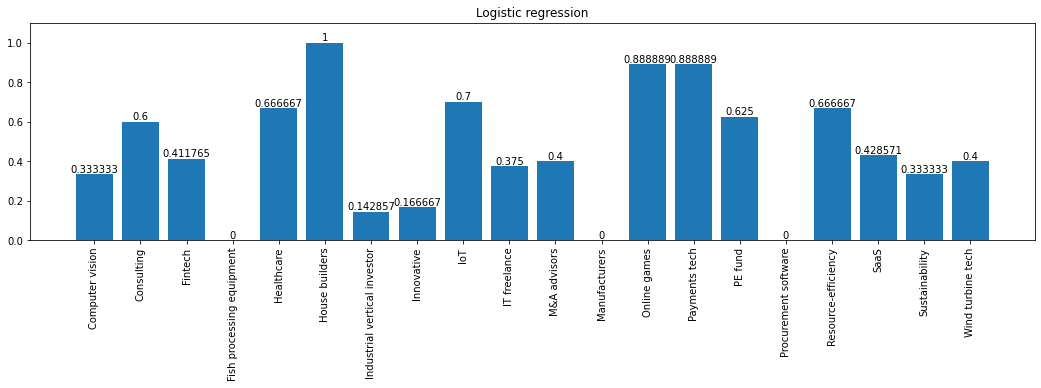

In [6]:
_, _ = plot_accuracies(accuracies, "Logistic regression")
plt.show()

In [8]:
precision, recall, _ = precision_recall_curve(y_test, preds)
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()

NameError: name 'preds' is not defined

#### XGBoost

In [7]:
accuracies = {}

for file_name in tqdm(file_names):
    dfc = DataFrameClassifier(dff=full_dff, glove_embeddings=glove_embeddings, file_name=file_name, verbose=False)
    
    X_train, y_train, X_test, y_test = dfc.get_feature_vectors(split=True)

    xg_reg = xgb.XGBRegressor()
    xg_reg.fit(X_train, y_train)
    
    accuracies[file_name] = mean_squared_error(y_test, xg_reg.predict(X_test))

100%|██████████| 20/20 [00:28<00:00,  1.41s/it]


In [8]:
print(f"Average accuracy: {np.mean(list(accuracies.values()))}")
print("---")
print(accuracies)

Average accuracy: 0.3287682705047167
---
{'Computer vision': 0.5829926879266095, 'Consulting': 0.2599179249908596, 'Fintech': 0.7901020708387515, 'Fish processing equipment': 0.009743193521391191, 'Healthcare': 0.5247178074045644, 'House builders': 0.05764914069221572, 'Industrial vertical investor': 0.8146567355589206, 'Innovative': 0.5223853108637538, 'IoT': 0.11897146140545622, 'IT freelance': 0.4502261097290491, 'M&A advisors': 0.19337170139688106, 'Manufacturers': 0.3533917805364792, 'Online games': 0.11030972157180323, 'Payments tech': 0.08651721437769755, 'PE fund': 0.25581572073674047, 'Procurement software': 1.010261966914229, 'Resource-efficiency': 0.2367873587888131, 'SaaS': 0.12085767127959914, 'Sustainability': 0.04076208395893725, 'Wind turbine tech': 0.03592774760158122}


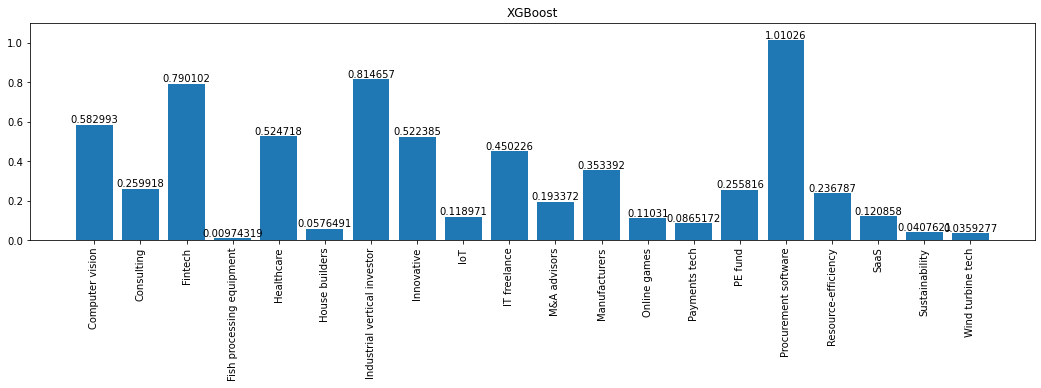

In [9]:
_, _ = plot_accuracies(accuracies, "XGBoost")
plt.show()

In [ ]:
precision, recall, _ = precision_recall_curve(y_test, preds)
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()

## Train one file, test on all others individually

#### Logistic

In [10]:

dfcs = {}
feature_vectors = {}
accuracies = [[] for _ in range(len(file_names))]

# Create all the dfcs once
for file_name in tqdm(file_names):
    dfcs[file_name] = DataFrameClassifier(dff=full_dff, glove_embeddings=glove_embeddings, file_name=file_name, verbose=False)
    feature_vectors[file_name] = dfcs[file_name].get_tfidf_vectors(split=False)

# Calculate the accuracies
for i, train_file in tqdm(enumerate(file_names)):

    X_train, y_train = feature_vectors[train_file]
    clf = LogisticRegression(random_state=0, class_weight='balanced', fit_intercept=False).fit(X_train, y_train)

    for test_file in file_names:
        X_test, y_test = feature_vectors[test_file]
        accuracies[i].append(clf.score(X_test,y_test))

100%|██████████| 20/20 [00:00<00:00, 20.46it/s]
20it [00:00, 246.56it/s]


In [11]:
avg_accuracies = [np.mean(x) for x in accuracies]
acc = dict(zip(file_names, avg_accuracies))

In [12]:
print(f"Average accuracy: {np.mean(list(acc.values()))}")
print("---")
print(acc)

Average accuracy: 0.5172205056663641
---
{'Computer vision': 0.5126361713684959, 'Consulting': 0.5099658661220753, 'Fintech': 0.5612378946039319, 'Fish processing equipment': 0.5270700196118001, 'Healthcare': 0.5196167404310216, 'House builders': 0.5182245036757065, 'Industrial vertical investor': 0.5277638838469259, 'Innovative': 0.5229147217310308, 'IoT': 0.5079836871968435, 'IT freelance': 0.47418506998396365, 'M&A advisors': 0.4899258469839742, 'Manufacturers': 0.5407465959324976, 'Online games': 0.5183710899798857, 'Payments tech': 0.5248711110883552, 'PE fund': 0.5386921307455868, 'Procurement software': 0.5045433963836388, 'Resource-efficiency': 0.518381997367978, 'SaaS': 0.5194357408492729, 'Sustainability': 0.5019584579299985, 'Wind turbine tech': 0.5058851874942998}


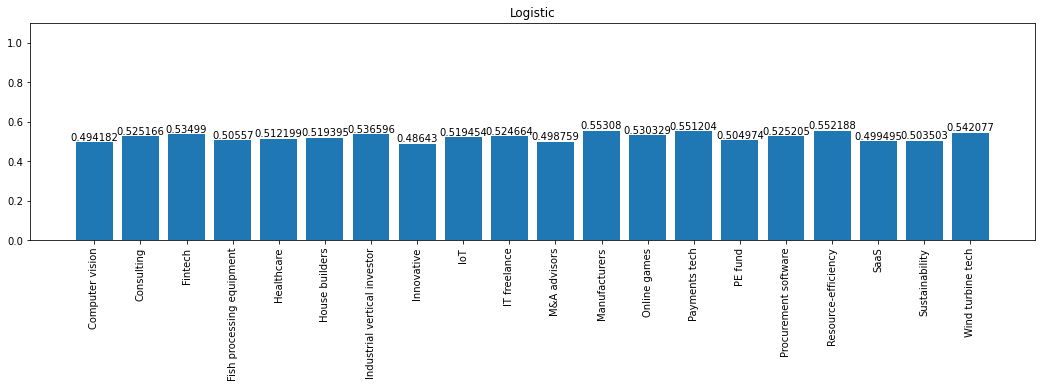

In [11]:
_,_ = plot_accuracies(acc, "Logistic")
plt.show()

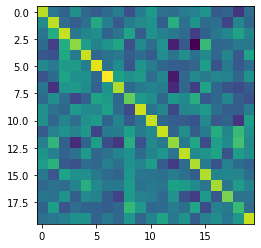

In [12]:
plt.imshow(accuracies)

#### XGBoost

In [ ]:
dfcs = {}
accuracies = [[] for _ in range(len(file_names))]
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror')#, colsample_bytree = 0.3, learning_rate = 0.1, max_depth = 5, alpha = 10, n_estimators = 10)

# Create all the dfcs once
for file_name in tqdm(file_names):
    dfcs[file_name] = DataFrameClassifier(dff=full_dff, glove_embeddings=glove_embeddings, file_name=file_name, verbose=False)

# Calculate the accuracies
for i, train_file in tqdm(enumerate(file_names)):

    X_train, y_train = dfcs[train_file].get_feature_vectors(split=False)

    for test_file in file_names:
        X_test, y_test = dfcs[test_file].get_feature_vectors(split=False)
        
        xg_reg.fit(X_train, y_train)
        preds = xg_reg.predict(X_test)
        score = np.sqrt(mean_squared_error(y_test, preds))
        
        accuracies[i].append(score)

100%|██████████| 20/20 [00:00<00:00, 93.51it/s]
20it [03:42, 11.11s/it]


In [ ]:
avg_accuracies = [np.mean(x) for x in accuracies]
acc = dict(zip(file_names, avg_accuracies))

In [ ]:
print(f"Average accuracy: {np.mean(list(acc.values()))}")
print("---")
print(acc)

Average accuracy: 0.5863521695741195
---
{'Computer vision': 0.5666327288986867, 'Consulting': 0.5617434543389521, 'Fintech': 0.6545732811802506, 'Fish processing equipment': 0.6270203141668713, 'Healthcare': 0.5692216719598185, 'House builders': 0.5326905857626879, 'Industrial vertical investor': 0.5781667883885295, 'Innovative': 0.5721678205000682, 'IoT': 0.6089150731122486, 'IT freelance': 0.5918838513183641, 'M&A advisors': 0.5380501988489267, 'Manufacturers': 0.5877542365856122, 'Online games': 0.6131780868363115, 'Payments tech': 0.5501260038314215, 'PE fund': 0.5839617422906812, 'Procurement software': 0.6203573506368796, 'Resource-efficiency': 0.5383919336957688, 'SaaS': 0.6338232291328937, 'Sustainability': 0.6327981366540881, 'Wind turbine tech': 0.5655869033433286}


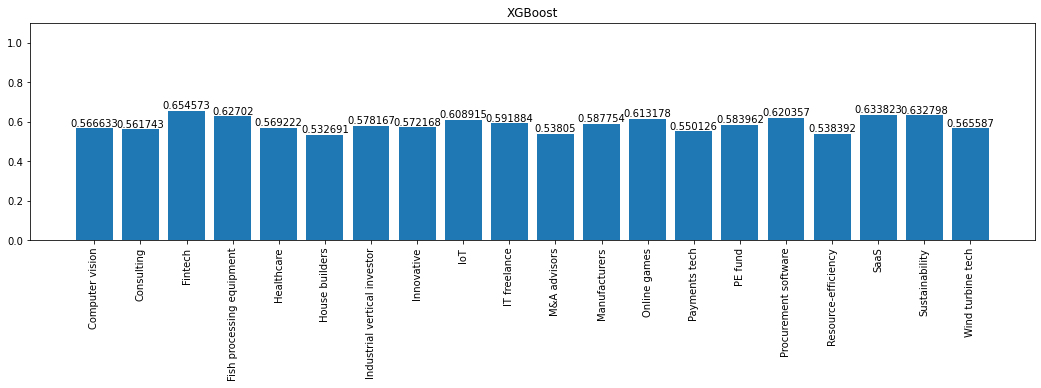

In [ ]:
_,_ = plot_accuracies(acc, "XGBoost")
plt.show()

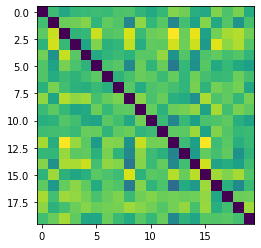

In [ ]:
plt.imshow(accuracies)

## Train all files except one, test on the last

#### Logistic

In [ ]:
dfcs = {}
accuracies = {}

# Create all the dfcs once
for file_name in tqdm(file_names):
    dfcs[file_name] = DataFrameClassifier(dff=full_dff, glove_embeddings=glove_embeddings, file_name=file_name, verbose=False)

# Calculate the accuracies
for test_file in tqdm(file_names):

    X_train, y_train = [], []
    X_test, y_test = dfcs[test_file].get_feature_vectors(split=False)
    
    for train_file in file_names:
        if train_file == test_file:
            continue
        new_X_train, new_y_train = dfcs[train_file].get_feature_vectors(split=False)
        X_train.extend(new_X_train)
        y_train.extend(new_y_train)
        
    clf = LogisticRegression(random_state=0, class_weight='balanced').fit(X_train, y_train)
    accuracies[test_file] = clf.score(X_test, y_test)

  0%|          | 0/20 [00:19<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
print(f"Average accuracy: {np.mean(list(accuracies.values()))}")
print("---")
print(accuracies)

Average accuracy: 0.5549981526861911
---
{'Computer vision': 0.5921052631578947, 'Consulting': 0.6229508196721312, 'Fintech': 0.3582089552238806, 'Fish processing equipment': 0.5942028985507246, 'Healthcare': 0.7666666666666667, 'House builders': 0.6785714285714286, 'Industrial vertical investor': 0.4782608695652174, 'Innovative': 0.631578947368421, 'IoT': 0.6774193548387096, 'IT freelance': 0.3442622950819672, 'M&A advisors': 0.625, 'Manufacturers': 0.5416666666666666, 'Online games': 0.26666666666666666, 'Payments tech': 0.6428571428571429, 'PE fund': 0.6176470588235294, 'Procurement software': 0.5081967213114754, 'Resource-efficiency': 0.2857142857142857, 'SaaS': 0.5272727272727272, 'Sustainability': 0.68, 'Wind turbine tech': 0.6607142857142857}


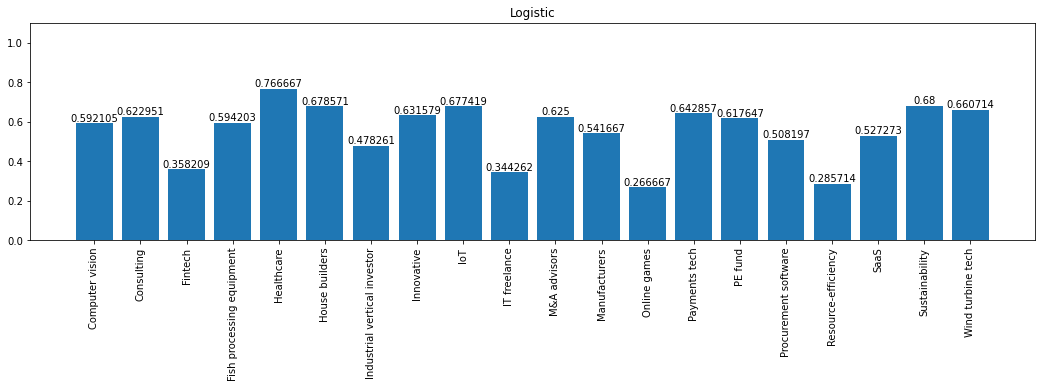

In [ ]:
_,_ = plot_accuracies(accuracies, "Logistic")
plt.show()

#### XGBoost

In [ ]:
dfcs = {}
accuracies = {}

xg_reg = xgb.XGBRegressor(objective ='reg:squarederror')

# Create all the dfcs once
for file_name in tqdm(file_names):
    dfcs[file_name] = DataFrameClassifier(dff=full_dff, glove_embeddings=glove_embeddings, file_name=file_name, verbose=False)

# Calculate the accuracies
for test_file in tqdm(file_names):

    X_train, y_train = [], []
    X_test, y_test = dfcs[test_file].get_feature_vectors(split=False)
    
    for train_file in file_names:
        if train_file == test_file:
            continue
        new_X_train, new_y_train = dfcs[train_file].get_feature_vectors(split=False)
        X_train.extend(new_X_train)
        y_train.extend(new_y_train)
        
    
    xg_reg.fit(X_train, y_train)
    preds = xg_reg.predict(X_test)
    score = np.sqrt(mean_squared_error(y_test, preds))
    
    accuracies[test_file] = score

100%|██████████| 20/20 [03:17<00:00,  9.89s/it]


In [ ]:
print(f"Average accuracy: {np.mean(list(accuracies.values()))}")
print("---")
print(accuracies)

Average accuracy: 0.5465978642541649
---
{'Computer vision': 0.548190316927572, 'Consulting': 0.41840956473518925, 'Fintech': 0.6108258305478755, 'Fish processing equipment': 0.5064315555251498, 'Healthcare': 0.5825461715070437, 'House builders': 0.5190802430878693, 'Industrial vertical investor': 0.5714688166583541, 'Innovative': 0.5192277340450587, 'IoT': 0.4714545522688264, 'IT freelance': 0.591736473377535, 'M&A advisors': 0.5039259442738117, 'Manufacturers': 0.6031444148289897, 'Online games': 0.5103487021497777, 'Payments tech': 0.5865123797786015, 'PE fund': 0.5174380865833266, 'Procurement software': 0.5443703808178287, 'Resource-efficiency': 0.6080774815194273, 'SaaS': 0.6406562604502892, 'Sustainability': 0.4757208134680511, 'Wind turbine tech': 0.6023915625327213}


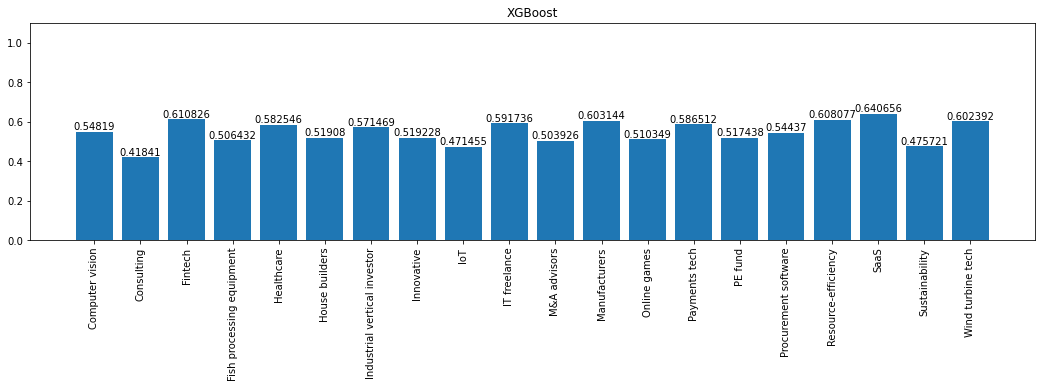

In [ ]:
_,_ = plot_accuracies(accuracies, "XGBoost")
plt.show()

# Crossvalidation 

## XGBoost

### Train

In [15]:

dfc = DataFrameClassifier(dff=full_dff, glove_embeddings=glove_embeddings, file_name='Computer vision')
X_train, y_train = dfc.get_feature_vectors(split=False)

dfc = DataFrameClassifier(dff=full_dff, glove_embeddings=glove_embeddings, file_name='Consulting')
X_test, y_test = dfc.get_feature_vectors(split=False)

xgb_model = xgb.XGBRegressor()
clf = GridSearchCV(xgb_model, {
    'booster' : ['gbtree', 'gblinear', 'dart'],
    'n_estimators' : [1, 5, 10, 20, 50],
    # 'gamma' : [0, 2, 5],
    # 'max_depth' : [2,4,10,12]
    }, 
    verbose=1,
    n_jobs=2
)
clf.fit(X_train, y_train)
print(f"Best score: {clf.best_score_}")
print(f"Best params: {clf.best_params_}")

* Reading CSV from path: data/train/Computer vision.csv. Size: (201, 3)
Initializing DataFrameFeatures object
* Reading CSV from path: data/train/Consulting.csv. Size: (182, 3)
Initializing DataFrameFeatures object
Fitting 5 folds for each of 15 candidates, totalling 75 fits
Best score: -0.21432124557678894
Best params: {'booster': 'gblinear', 'n_estimators': 1}


### Test

In [39]:
from sklearn.metrics import accuracy_score

xg_reg = xgb.XGBRegressor()#booster = 'gblinear', n_estimators = 1)
xg_reg.fit(X_train, y_train)
xg_reg.score(X_test,y_test)

threshold = 0.6

for i in range(0,10):
    threshold = i * 0.1
    preds = xg_reg.predict(X_test)
    preds = (threshold <= preds).astype(int)

    print(i, accuracy_score(y_test,preds))
# score = np.sqrt(mean_squared_error(y_test, preds))
# score

0 0.7377049180327869
1 0.7377049180327869
2 0.7213114754098361
3 0.6721311475409836
4 0.639344262295082
5 0.6065573770491803
6 0.5245901639344263
7 0.45901639344262296
8 0.39344262295081966
9 0.2786885245901639


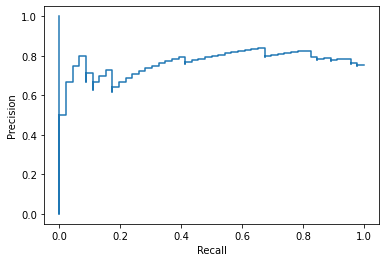

In [41]:
preds = xg_reg.predict(X_test)
precision, recall, _ = precision_recall_curve(y_test, preds)
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()

In [43]:
from sklearn import metrics

fpr, tpr, thresholds = metrics.roc_curve(y_test, preds, pos_label=1)
metrics.auc(fpr, tpr)

0.572463768115942

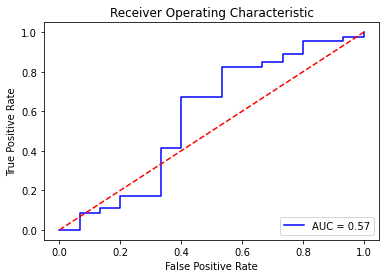

In [47]:
from sklearn import metrics
def buildROC(target_test,test_preds):
    fpr, tpr, threshold = metrics.roc_curve(target_test, test_preds)
    roc_auc = metrics.auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')

buildROC(y_test,preds)

In [ ]:
dfc1 = DataFrameClassifier(dff=full_dff, glove_embeddings=glove_embeddings, file_name='Consulting', verbose=False)
dfc2 = DataFrameClassifier(dff=full_dff, glove_embeddings=glove_embeddings, file_name='SaaS', verbose=False)

X_train, y_train = dfc1.get_tfidf_vectors()
X_test, y_test = dfc2.get_tfidf_vectors()

xg = xgb.XGBClassifier(use_label_encoder=False, eval_metric='map')
xg.fit(X_train, y_train)

preds = xg.predict(X_test)
precision, recall, _ = precision_recall_curve(y_test, preds)

disp = PrecisionRecallDisplay(precision=precision, recall=recall)

disp.plot()